* Images are made up of pixels
* In color images, every pixel is a RGB value.
* Range 0-255
* In greyscale images, each pixel represents intensity(0-1)
* color image has 3 channels, whereas greyscale has 1.

In [16]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [3]:
filename = 'sample.JPG'

In [8]:
image = img.imread(filename)

In [10]:
print('Image Shape', image.shape)

Image Shape (768, 1024, 3)


* We can print contents of image

In [11]:
print(image)

[[[ 20  86   0]
  [ 17  86   0]
  [ 17  85   0]
  ..., 
  [ 13  87   0]
  [ 16  90   3]
  [ 18  92   3]]

 [[ 23  89   1]
  [ 21  90   1]
  [ 20  88   1]
  ..., 
  [ 11  85   0]
  [ 14  88   1]
  [ 17  91   2]]

 [[ 22  88   0]
  [ 20  89   0]
  [ 19  87   0]
  ..., 
  [ 12  86   0]
  [ 15  89   2]
  [ 18  92   3]]

 ..., 
 [[ 35 108   1]
  [ 35 108   1]
  [ 33 106   1]
  ..., 
  [ 26  48   0]
  [ 23  50   0]
  [ 22  50   0]]

 [[ 33 109   1]
  [ 33 109   1]
  [ 34 107   2]
  ..., 
  [ 30  46   0]
  [ 30  48   0]
  [ 30  48   0]]

 [[ 34 110   2]
  [ 33 109   1]
  [ 34 107   2]
  ..., 
  [ 34  46   0]
  [ 34  46   0]
  [ 34  46   0]]]


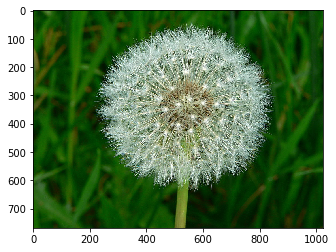

In [13]:
plt.imshow(image)
plt.show()

In [14]:
from PIL import Image

In [15]:
orig_list = ['prestige-476863311.jpg', 'sunset.jpg', 'pexels-photo.jpg', 'embed2.jpg']

create a queue of this filenames

In [17]:
file_q = tf.train.string_input_producer(orig_list)

In [30]:
img_reader = tf.WholeFileReader()

In [31]:
with tf.Session() as sess:
    coord = tf.train.Coordinator()#coordinates the multiple threads
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    image_list = []
    for i in range(len(orig_list)):
        _,img_file =img_reader.read(file_q)
        image = tf.image.decode_jpeg(img_file)# it will convert image to a tensor
        
#         Resize image tensor
        image = tf.image.resize_images(image,[500,500])
        image.set_shape((500,500,3))
        
        image_array = sess.run(image)
        print(image_array.shape)
        
#         Image.fromarray(image_array.astype('uint8'), 'RGB').show()# to display images
        image_list.append(tf.expand_dims(image_array,0))# it adds a new D to make it 4D
# Request to stop all threads
    coord.request_stop()
    coord.join()
    index = 0

# Write image summary
    summ_writer = tf.summary.FileWriter('m4_ex',graph=sess.graph)
    for img_tensor in image_list:
        summ_str = sess.run(tf.summary.image('image-'+str(index),img_tensor))
        summ_writer.add_summary(summ_str)
        index+=1
    summ_writer.close()

(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)


* Tensorflow deals with list of images as a 4D tensor
* (10,6,6,3) 
* Here 10 is num of image, 6-height, 6-width, 3-channels
* tf.stack converts a numpy list to a tensor
* If we have a numpy list it will convert to a 4D tensor

### Image Similarity Using L1 Distance

* Euclidean distance is used for continuous variables(as the crow flies).
* L1 Distance(diff b/w x and y coordinates)


In [32]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_dataput_data

1. Download dataset

In [51]:
mnist = input_data.read_data_sets('mnist_data',one_hot=True)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


* one_hot will have 10-length binary vector with 0s and 1(at the position of digit)

In [46]:
train_digits, train_labels = mnist.train.next_batch(5000)
test_digits, test_labels = mnist.test.next_batch(200)

In [67]:
print(train_labels)

[[ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]]


listed as  10-length binary vecto 

In [68]:
print(train_digits)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [74]:
print(len(train_digits))

5000


In [73]:
print(len(train_digits[0]))

784


In [37]:
train_pl = tf.placeholder('float',[None,784])

* None- num of images is unknown

In [38]:
test_pl = tf.placeholder('float', [784])


2. Calculate L1 distance

In [59]:
l1_dist = tf.abs(tf.add(train_pl, tf.negative(test_pl)))

In [41]:
dist = tf.reduce_sum(l1_dist,axis=1)

In [75]:
pred = tf.argmin(dist,0)

it will give the training image having the smallest distance
np.argmax() for a one_hot will give the index having 1 that is , the actual label

In [61]:
acc = 0.

In [64]:
init = tf.global_variables_initializer()

3. Run the model

In [65]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(len(test_digits)):
        nn_index = sess.run(pred, feed_dict={train_pl:train_digits,test_pl:test_digits[i]})
        print('Test',i,'Prediction:',np.argmax(train_labels[nn_index]),'True Label',np.argmax(test_labels[i]))
        
        if np.argmax(train_labels[nn_index]) == np.argmax(test_labels[i]):
            acc +=1./len(test_digits)
    

Test 0 Prediction: 9 True Label 4
Test 1 Prediction: 3 True Label 3
Test 2 Prediction: 9 True Label 9
Test 3 Prediction: 3 True Label 3
Test 4 Prediction: 2 True Label 2
Test 5 Prediction: 0 True Label 0
Test 6 Prediction: 6 True Label 6
Test 7 Prediction: 8 True Label 8
Test 8 Prediction: 9 True Label 9
Test 9 Prediction: 3 True Label 3
Test 10 Prediction: 3 True Label 3
Test 11 Prediction: 2 True Label 2
Test 12 Prediction: 8 True Label 8
Test 13 Prediction: 0 True Label 0
Test 14 Prediction: 0 True Label 0
Test 15 Prediction: 5 True Label 5
Test 16 Prediction: 1 True Label 1
Test 17 Prediction: 6 True Label 6
Test 18 Prediction: 7 True Label 7
Test 19 Prediction: 9 True Label 9
Test 20 Prediction: 7 True Label 7
Test 21 Prediction: 1 True Label 1
Test 22 Prediction: 3 True Label 3
Test 23 Prediction: 7 True Label 7
Test 24 Prediction: 6 True Label 6
Test 25 Prediction: 9 True Label 9
Test 26 Prediction: 3 True Label 3
Test 27 Prediction: 2 True Label 2
Test 28 Prediction: 5 True Lab

In [66]:
print(acc)

0.9650000000000007
